# Model Metrics

* **Last Modified**: 07-04-2021
* **Authors**: Sam Budd, Gonzalo Mateo-García
---

This notebook shows how to compute metrics for a trained model on the *WorldFloods* test dataset. The notebook is divided in 4 steps:

1. Load the config file of the experiment.
1. Create a dataloader for the test dataset.
1. Create the segmentation model and load their weights
1. Run inference on all images in the dataset and compute metrics

In [ ]:
# !pip install git+https://github.com/spaceml-org/ml4floods#egg=ml4floods

In [1]:
import sys, os
from pathlib import Path

# %load_ext autoreload
# %autoreload 2

## Step 1: Get config

In [2]:
from ml4floods.models.config_setup import get_default_config
from imp import reload

experiment_name = "WFV1_unet"
# checkpoint_name = "epoch=24-step=153649.ckpt"

# experiment_name = "WFV1_scnn20"
# checkpoint_name = "epoch=5-step=24581.ckpt"

# V2 models
# experiment_name = "WF2_unet"
# checkpoint_name = "epoch=5-step=24215.ckpt"

config_fp = f"gs://ml4cc_data_lake/2_PROD/2_Mart/2_MLModelMart/{experiment_name}/config.json"
# config_fp = os.path.join(root, 'src', 'models', 'configurations', 'worldfloods_template.json')
config = get_default_config(config_fp)
config["model_params"]["max_tile_size"] = 1024

Loaded Config for experiment:  WFV1_unet
{   'data_params': {   'batch_size': 32,
                       'bucket_id': 'ml4floods',
                       'channel_configuration': 'all',
                       'filter_windows': False,
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 8,
                       'path_to_splits': '/worldfloods/public',
                       'target_folder': 'gt',
                       'test_transformation': {   'normalize': True,
                                                  'num_classes': 3,
                                                  'totensor': True},
                       'train_test_split_file': 'worldfloods/public/train_test_split.json',
                       'train_transformation': {   'normalize': True,
                                                   'num_classes': 3,
                                                   'totensor': True},
                

## Step 2: Load dataloader

In [5]:
from ml4floods.models import dataset_setup

config.data_params.loader_type = 'local'
config.data_params.path_to_splits = "/worldfloods/v1" # local folder to download the data
config.data_params.bucket_id = "ml4cc_data_lake" 
config.data_params.train_test_split_file = "2_PROD/2_Mart/worldfloods_v1_0/train_test_split.json" 

config.data_params["download"] = {"train": False, "val": False, "test": True} # download only test data

if "filter_windows" in config["data_params"]:
    del config["data_params"]["filter_windows"]


In [6]:
data_module = dataset_setup.get_dataset(config["data_params"])

Using local dataset for this run
Skip download train
Skip download val
train 2424  tiles
val 1284  tiles
test 11  tiles


In [7]:
dl = data_module.test_dataloader()
# dl = data_module.val_dataloader()

## Step 3: Load a trained model

In [8]:
from ml4floods.models.model_setup import get_model

config["model_params"]['model_folder'] = 'gs://ml4cc_data_lake/2_PROD/2_Mart/2_MLModelMart'
config["model_params"]['test'] = True
model = get_model(config.model_params, experiment_name)

model.eval()
# model.to("cpu")

Loaded model weights: gs://ml4cc_data_lake/2_PROD/2_Mart/2_MLModelMart/WFV1_unet/model.pt


WorldFloodsModel(
  (network): UNet(
    (dconv_down1): Sequential(
      (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), 

## Step 4: Run inference on all the images in the test dataset

In [14]:
from ml4floods.models.model_setup import get_model_inference_function

if config["model_params"].get("model_version","v1") == "v2":
    inf_func = get_model_inference_function(model, config, apply_normalization=False, 
                                        activation="sigmoid")
    print("v2 inference function converted to v1")
    def inference_function(x):
        dual_head_output = inf_func(x)
        B, C, H, W = dual_head_output.shape
        out = torch.zeros((B, 3, H, W),dtype=dual_head_output.dtype)
        out[:, 2] = dual_head_output[:, 0]
        out[:, 1] = (1 - dual_head_output[:, 0]) * dual_head_output[:, 1]
        out[:, 0] = (1 - dual_head_output[:, 0]) * (1 - dual_head_output[:, 1])
        return out
else:
    inf_func = get_model_inference_function(model, config, apply_normalization=False, 
                                            activation="softmax")
    def inference_function(x):
        return inf_func(x)[:, 1:2]
    

Getting model inference function
Max tile size: 1024


100%|██████████| 11/11 [26:48<00:00, 146.25s/it]


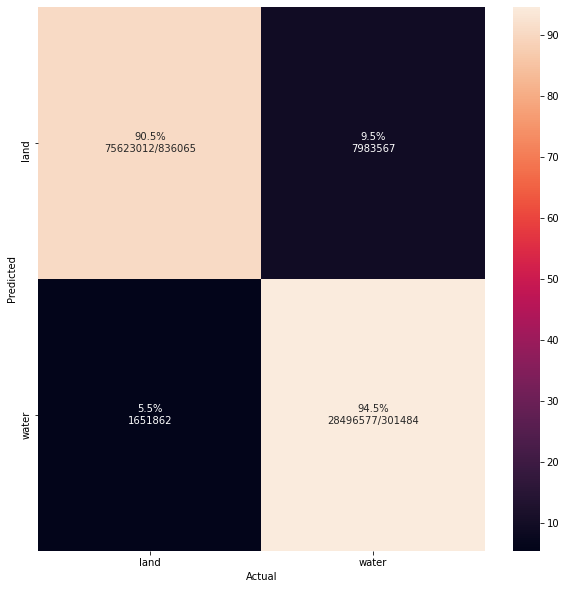

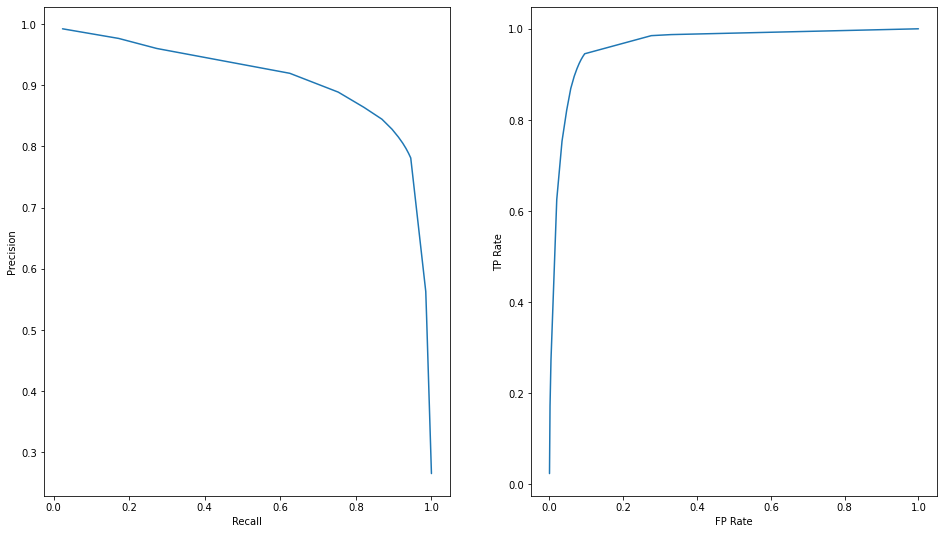

Per Class IOU {
    "land": 0.886985629962456,
    "water": 0.7473138706629214
}
CPU times: user 1h 12min 21s, sys: 14min 59s, total: 1h 27min 20s
Wall time: 26min 49s


In [15]:
%%time

import torch
import numpy as np
import pandas as pd
from ml4floods.models.utils import metrics

# Otherwise fails when reading test dataset from remote bucket
# torch.set_num_threads(1)

thresholds_water = [0,1e-3,1e-2]+np.arange(0.5,.96,.05).tolist() + [.99,.995,.999]

mets = metrics.compute_metrics(
    dl,
    inference_function, 
    thresholds_water=thresholds_water, 
    mask_clouds=True,
    plot=False)

label_names = ["land", "water"]
metrics.plot_metrics(mets, label_names)

In [21]:
import json
from ml4floods.data.utils import CustomJSONEncoder
with open("confs_unet.json", "w") as fh:
    json.dump(mets, fh,cls=CustomJSONEncoder)

## Bonus: Compute the metrics for each flood in the test dataset

In [23]:
CODES_LOC = {"EMSR333": "EMSR333 (Italy)",
             "EMSR9284": "EMSR284 (Finland)",
             "EMSR347": "EMSR347 (Malawi)",
             "EMSR286": "EMSR286 (Colombia)",
             "EMSR342": "EMSR342 (Australia)"
            }

if hasattr(dl.dataset, "image_files"):
    cems_code = [os.path.basename(f).split("_")[0] for f in dl.dataset.image_files]
else:
    cems_code = [os.path.basename(f.file_name).split("_")[0] for f in dl.dataset.list_of_windows]

iou_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"], cems_code, metrics.calculate_iou,
                                                    label_names=[f"IoU_{l}"for l in label_names]))

recall_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_recall,
                                                       label_names=[f"Recall_{l}"for l in label_names]))

join_data_per_code = pd.merge(recall_per_code,iou_per_code,on="code")
join_data_per_code["code"] = join_data_per_code["code"].apply(lambda x: CODES_LOC.get(x,x))
join_data_per_code = join_data_per_code.set_index("code")
join_data_per_code = join_data_per_code*100
print(f"Mean values across flood events: {join_data_per_code.mean(axis=0).to_dict()}")
join_data_per_code

Mean values across flood events: {'Recall_land': 91.52573941861696, 'Recall_water': 91.68340023029785, 'IoU_land': 90.41267220814505, 'IoU_water': 74.83775500818484}


,Recall_land,Recall_water,IoU_land,IoU_water
code,,,,
EMSR286 (Colombia),98.999642,96.037458,98.687782,85.333344
EMSR333 (Italy),97.508000,86.472094,96.757042,60.286360
EMSR342 (Australia),70.840026,96.952482,68.835375,74.284838
EMSR347 (Malawi),99.484285,81.622685,97.821419,77.312288
EMSR284 (Finland),90.796744,97.332282,89.961744,76.971944
